## Preprocessing

In [1]:
!pip install pmdarima -q

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
from pmdarima.arima import auto_arima

In [3]:
df = pd.read_csv('nyc_energy_consumption.csv', names = ['timeStamp','demand','precip','temp'])

In [4]:
# Making sure we got the columns correct
df = df.loc[1:].reset_index(drop=True)
print(df.head())
print(df.isnull().any())

             timeStamp  demand precip   temp
0  2012-01-01 00:00:00  4937.5    0.0  46.13
1  2012-01-01 01:00:00  4752.1    0.0  45.89
2  2012-01-01 02:00:00  4542.6    0.0  45.04
3  2012-01-01 03:00:00  4357.7    0.0  45.03
4  2012-01-01 04:00:00  4275.5    0.0  42.61
timeStamp    False
demand        True
precip        True
temp          True
dtype: bool


In [5]:
# datetime conversion
df['timeStamp'] = pd.to_datetime(df['timeStamp'])

# Make sure 'demand' and 'temp' is of type float
df['demand'] = df['demand'].astype(float)
df['temp'] = df['temp'].astype(float)

# Forward filling
df['demand']=df['demand'].fillna(method='ffill')
df['temp']=df['temp'].fillna(method='ffill')

print(df.isnull().any())

# Dont need this ?
df = df.drop('precip', axis=1)

timeStamp    False
demand       False
precip        True
temp         False
dtype: bool


In [6]:
# Exogenous variable initialization
df["month"] = df.timeStamp.dt.month
df["week"] = df.timeStamp.dt.isocalendar().week
df["day"] = df.timeStamp.dt.day
df["day_of_week"] = df.timeStamp.dt.dayofweek

# Resampling to monthly data
df_normal = df
df = df.resample('M', on ='timeStamp').mean()
df.head()

,demand,temp,month,week,day,day_of_week
timeStamp,,,,,,
2012-01-31,5757.495833,37.174288,1.0,4.258065,16.0,2.935484
2012-02-29,5622.331609,40.448046,2.0,6.862069,15.0,2.965517
2012-03-31,5479.919198,49.607917,3.0,11.129032,16.0,3.096774
2012-04-30,5368.945833,54.255903,4.0,15.5,15.5,3.000000
2012-05-31,5867.896102,64.188078,5.0,19.870968,16.0,2.903226


## EDA

In [7]:
# Interactive Plot

exogen_var = ["temp",'month','week','day','day_of_week']
df_reset = df.reset_index()
fig = px.line(df_reset, x='timeStamp', y='demand', title='NYC Energy Demand')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=2, label="3m", step="month", stepmode="backward"),
            dict(count=3, label="5m", step="month", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

In [8]:
# Split the data into four subsets for each season
spring_data = df_normal[df_normal['month'].isin([3, 4, 5])]
summer_data = df_normal[df_normal['month'].isin([6, 7, 8])]
autumn_data = df_normal[df_normal['month'].isin([9, 10, 11])]
winter_data = df_normal[df_normal['month'].isin([12, 1, 2])]

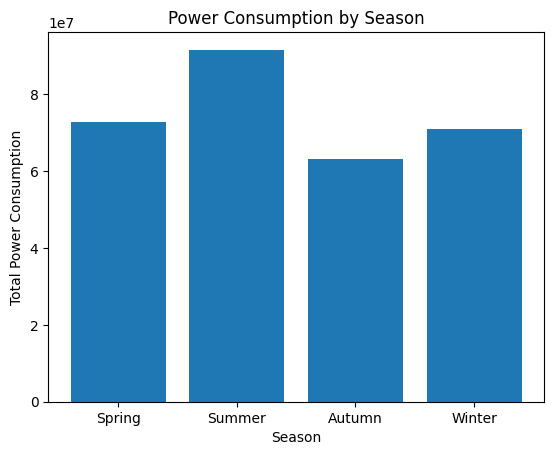

The season with the highest power consumption overall is Summer


In [9]:
# Calculate the total power consumption for each season
spring_power = spring_data['demand'].sum()
summer_power = summer_data['demand'].sum()
autumn_power = autumn_data['demand'].sum()
winter_power = winter_data['demand'].sum()

# Find the season with the highest power consumption
seasons = ['Spring', 'Summer', 'Autumn', 'Winter']
power_consumptions = [spring_power, summer_power, autumn_power, winter_power]
highest_consumption_season = seasons[power_consumptions.index(max(power_consumptions))]

# Plot the total power consumption for each season
plt.bar(seasons, power_consumptions)
plt.xlabel('Season')
plt.ylabel('Total Power Consumption')
plt.title('Power Consumption by Season')
plt.show()

print("The season with the highest power consumption overall is", highest_consumption_season)

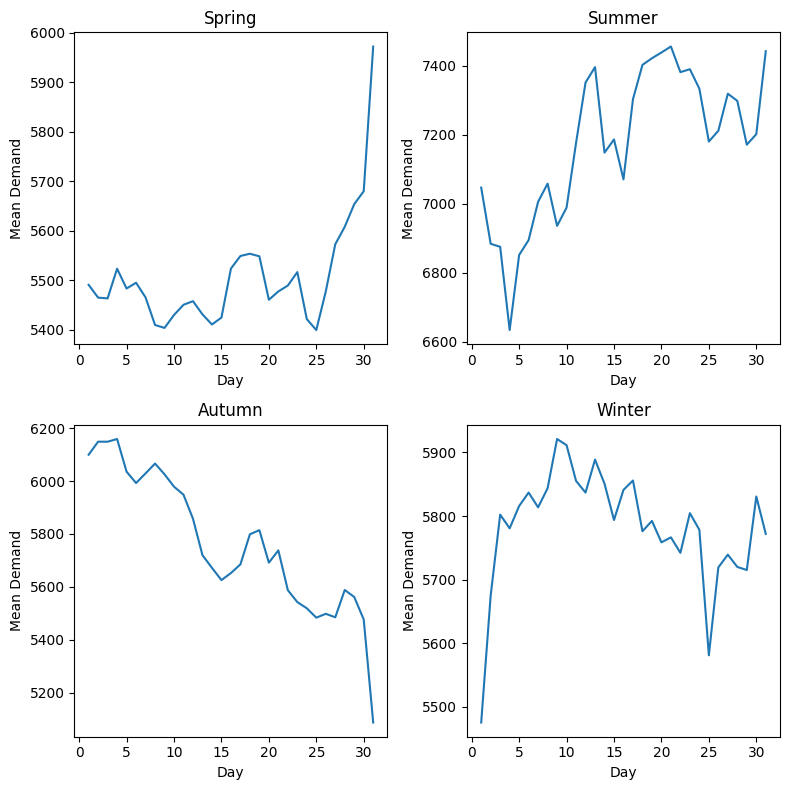

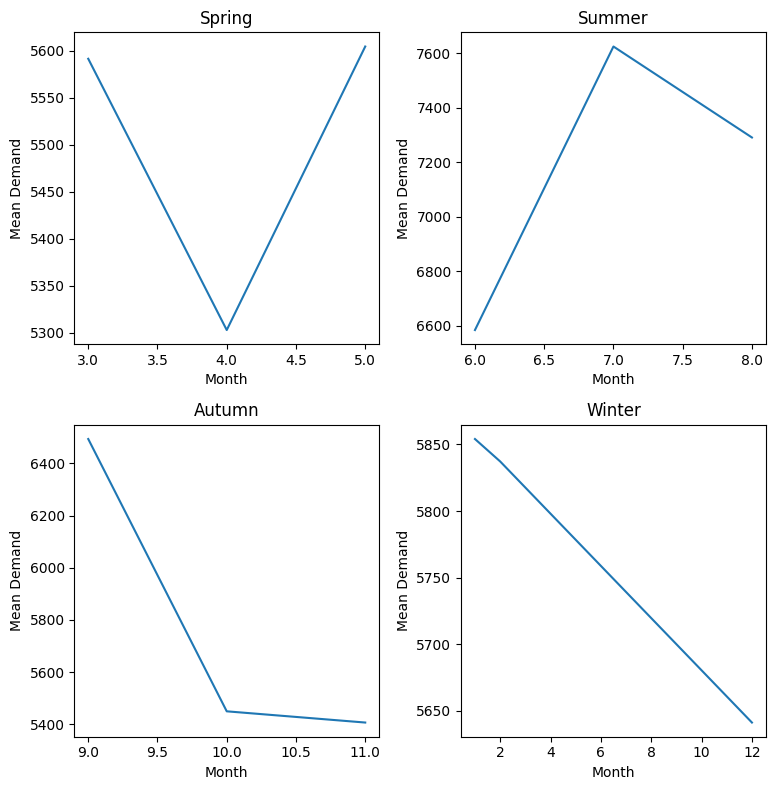

In [10]:
def create_plot(spring_mean_demand, summer_mean_demand, autumn_mean_demand, winter_mean_demand, dt_type):
  # Create subplots
  fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

  # Plot mean demand per day for each season
  axes[0, 0].plot(spring_mean_demand)
  axes[0, 0].set_title('Spring')
  axes[0, 0].set_xlabel(dt_type)
  axes[0, 0].set_ylabel('Mean Demand')

  axes[0, 1].plot(summer_mean_demand)
  axes[0, 1].set_title('Summer')
  axes[0, 1].set_xlabel(dt_type)
  axes[0, 1].set_ylabel('Mean Demand')

  axes[1, 0].plot(autumn_mean_demand)
  axes[1, 0].set_title('Autumn')
  axes[1, 0].set_xlabel(dt_type)
  axes[1, 0].set_ylabel('Mean Demand')

  axes[1, 1].plot(winter_mean_demand)
  axes[1, 1].set_title('Winter')
  axes[1, 1].set_xlabel(dt_type)
  axes[1, 1].set_ylabel('Mean Demand')

  # Adjust layout and display the plots
  plt.tight_layout()
  plt.show()

# Calculate mean demand per day for each season
spring_mean_demand = spring_data.groupby('day')['demand'].mean()
summer_mean_demand = summer_data.groupby('day')['demand'].mean()
autumn_mean_demand = autumn_data.groupby('day')['demand'].mean()
winter_mean_demand = winter_data.groupby('day')['demand'].mean()

create_plot(spring_mean_demand, summer_mean_demand, autumn_mean_demand, winter_mean_demand, 'Day')

# Calculate mean demand per day for each season
spring_mean_demand = spring_data.groupby('month')['demand'].mean()
summer_mean_demand = summer_data.groupby('month')['demand'].mean()
autumn_mean_demand = autumn_data.groupby('month')['demand'].mean()
winter_mean_demand = winter_data.groupby('month')['demand'].mean()

create_plot(spring_mean_demand, summer_mean_demand, autumn_mean_demand, winter_mean_demand, 'Month')

## Params

Find m,p,d,q if possible

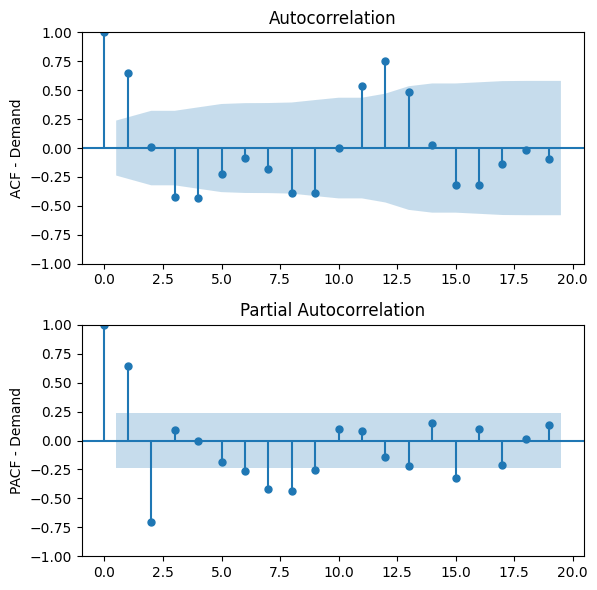

In [11]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6))

# Plot ACF for 'demand' in the first subplot
plot_acf(df['demand'].dropna(), ax=ax1)
ax1.set_ylabel('ACF - Demand')

# Plot PACF for 'temp' in the second subplot
plot_pacf(df['demand'].dropna(), ax=ax2)
ax2.set_ylabel('PACF - Demand')

# Display the plot
plt.tight_layout()
plt.show()

m = 12 (spikes at multiples of 12 in acf) and min p=2 ?

In [12]:
m = 12
start_p = 2
df_train = df[df.index <= "2017-04-01"]
df_test = df[df.index > "2017-04-30"]

## Try STL decomposition then forecasting

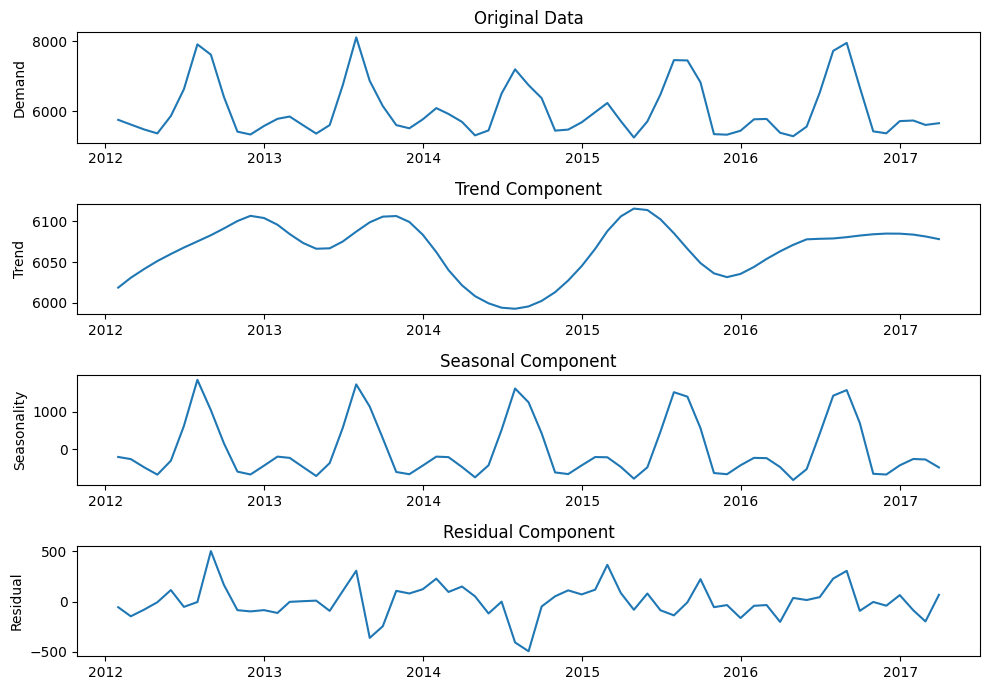

In [13]:
# Perform STL decomposition
stl = STL(df_train['demand'], seasonal=13)  # Assuming 12-seasonal period (annual data)
res = stl.fit()

# Extract the trend, seasonal, and residual components
trend = res.trend
seasonal = res.seasonal
residual = res.resid

# Plot the components
plt.figure(figsize=(10, 7))
plt.subplot(4, 1, 1)
plt.plot(df_train.index, df_train['demand'])
plt.title('Original Data')
plt.ylabel('Demand')

plt.subplot(4,1, 2)
plt.plot(df_train.index, trend)
plt.title('Trend Component')
plt.ylabel('Trend')

plt.subplot(4, 1, 3)
plt.plot(df_train.index, seasonal)
plt.title('Seasonal Component')
plt.ylabel('Seasonality')

plt.subplot(4, 1, 4)
plt.plot(df_train.index, residual)
plt.title('Residual Component')
plt.ylabel('Residual')

plt.tight_layout()
plt.show()

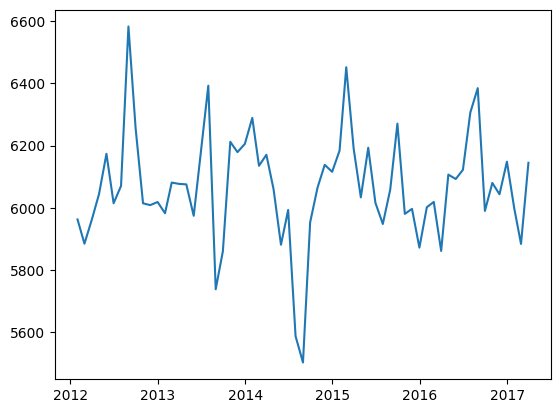

In [14]:
forecast_seasonal = seasonal[:len(df_test)]
seasonally_adjusted = res.observed - res.seasonal
plt.plot(seasonally_adjusted)

Seasonally Adjusted data seems to be too complex, lets leave it

## Model Building

In [15]:
model = auto_arima(df.demand,
                        m=m,seasonal=True, exogenous=df_train[exogen_var],
                      start_p=start_p, start_q=0, start_d=0,test='adf',error_action='ignore',
                           suppress_warnings=True,
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1100.321, Time=0.09 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1023.743, Time=1.47 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1380.758, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=1065.516, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=1024.640, Time=3.71 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=1.28 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=inf, Time=1.24 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=4.28 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=1101.718, Time=0.61 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=1014.059, Time=3.11 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=1021.211, Time=0.61 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=1021.850, Time=3.53 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=99

In [16]:
model.fit(df_train.demand, exogenous=df_train[exogen_var])

ARIMA(order=(2, 0, 0), scoring_args={}, seasonal_order=(0, 0, 2, 12),
      suppress_warnings=True)

In [17]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                   63
Model:             SARIMAX(2, 0, 0)x(0, 0, [1, 2], 12)   Log Likelihood                -453.566
Date:                                 Tue, 26 Sep 2023   AIC                            919.133
Time:                                         15:50:06   BIC                            931.991
Sample:                                     01-31-2012   HQIC                           924.190
                                          - 03-31-2017                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3628.2841    769.516      4.715      0.000    2120.060    5136.509
ar.L1          0.9093      0.117      7.770      0.000       0.680       1.139
ar.L2         -0.5058      0.129     -3.914      0.000      -0.759      -0.253
ma.S.L12       0.8450      0.134      6.306      0.000       0.582       1.108
ma.S.L24       0.4230      0.235      1.803      0.071      -0.037       0.883
sigma2      8.824e+04   1.64e+04      5.384      0.000    5.61e+04     1.2e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 6.10
Prob(Q):                              0.77   Prob(JB):                         0.05
Heteroskedasticity (H):               0.81   Skew:                             0.55
Prob(H) (two-sided):                  0.63   Kurtosis:                         4.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
# Obtain forecasts
forecast_values = model.predict(n_periods=len(df_test), exogenous=df_test[exogen_var], return_conf_int=True)

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
print("RMSE of Auto ARIMAX:", mean_squared_error(df_test.demand, forecast_values[0], squared=False))
print("MAPE of Auto ARIMAX:", mean_absolute_percentage_error(df_test.demand, forecast_values[0]))

RMSE of Auto ARIMAX: 653.4002145810057
MAPE of Auto ARIMAX: 0.09295006180153564


<Axes: xlabel='timeStamp'>

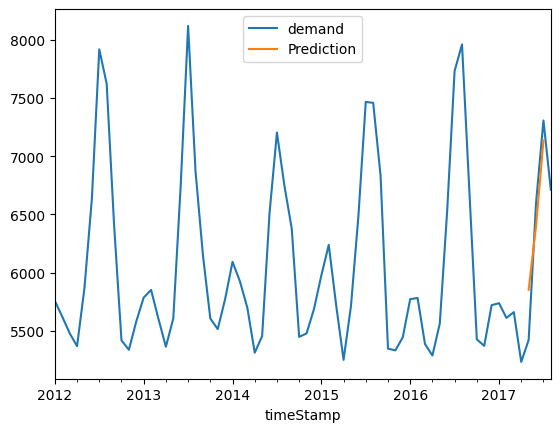

In [19]:
forecast_df = pd.DataFrame(forecast_values[0],index = df_test.index,columns=['Prediction'])

pd.concat([df['demand'],forecast_df],axis=1).plot()

<Axes: >

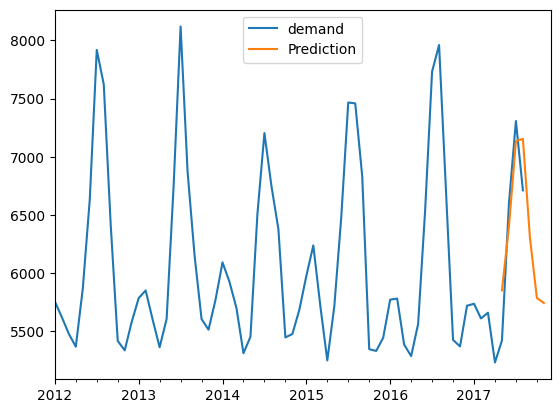

In [20]:
forecast1=model.predict(n_periods=8, return_conf_int=True)
forecast_range=pd.date_range(start='2017-05-31', periods=8,freq='M')
forecast1_df = pd.DataFrame(forecast1[0],index =forecast_range,columns=['Prediction'])
pd.concat([df['demand'],forecast1_df],axis=1).plot()

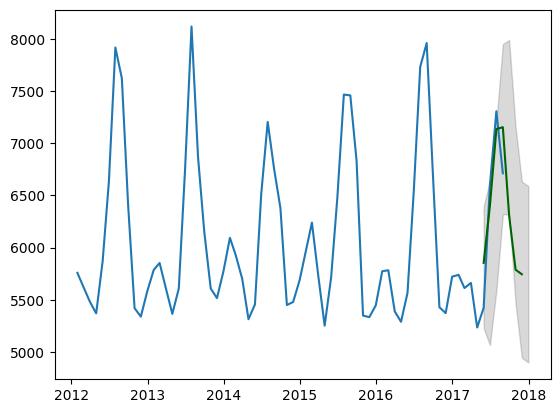

In [21]:
lower=pd.Series(forecast1[1][:, 0], index =forecast_range)
upper=pd.Series(forecast1[1][:, 1], index =forecast_range)

plt.plot(df['demand'])
plt.plot(forecast1_df, color='darkgreen')
plt.fill_between(forecast_range,
                 lower,
                 upper,
                 color='k', alpha=.15)